# Практическое задание 3 

# Классификация с использованием BERT

## курс "Математические методы анализа текстов"


### ФИО: Волынцев Дмитрий Александрович

## Введение

### Постановка задачи

В этом задании вы будете классифицировать пары вопросов из stack overflow на предмет дубликатов.
Чтобы получить гораздо более высокое качество на гораздо меньшем количестве данных, чем DSSM, предлагается дообучать предобученную модель BERT.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Transformers](https://github.com/huggingface/transformers).
 
### Данные

Данные лежат в архиве task3_data.zip, который состоит из:

* train.tsv - обучающая выборка. В каждой строке записаны: <вопрос 1>, <вопрос 2>, <таргет>

* validation.tsv - dev выборка, которую можно использовать для подбора гиперпарамеров; например, для ранней остановки. В каждой строке через табуляцию записаны: , <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...

* test.tsv - тестовая выборка, по которой оценивается итоговое качество. В каждой строке через табуляцию записаны: , <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...

Скачать данные можно здесь: [ссылка на google диск](https://drive.google.com/file/d/1Owb5Vpv7mVjksYo7gD9VuHkMETkzhIdr/view?usp=sharing)

## Часть 1. Подготовка данных (1 балл)

Мы будем работать с теми же данными, которые были в первом задании. А также будем учиться классифицировать пары вопросов аналогично третьей части в первом задании. Теперь выборка для обучения сгенерирована заранее :)

In [1]:
import pandas as pd
import numpy as np

import tqdm
import os
import tests

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Путь к папке с данными:

In [4]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/'

Считывание данных для обучения:

In [5]:
train = pd.read_table(os.path.join(DATA_PATH, 'train.tsv'))

In [6]:
train

,question_1,question_2,target
0,How to store an Array[String] to an output file,Rails ActiveJob Background Job Keeps Pinging M...,0
1,Pass a function return to another in the same row,jQuery AJAX submit form,0
2,Is there a RegExp.escape function in Javascript?,Using my own method with LINQ to Entities,0
3,How to update Google Play Services for Android...,Visual Studio keeps crashing: Application Error,0
4,Using comet with PHP?,Group by followed by select only rows if its v...,0
...,...,...,...
599995,animate the fill color in cylinder from bottom...,Fill color with animation,1
599996,Using %f to print an integer variable,using printf to print out floating values,1
599997,How to handle session end in global.asax?,LOAD SQL Table from flat file,0
599998,Is there a good reason for always enclosing a ...,Access CKEditor iframe's style tags with jQuery,0


Модель **BERT** использует специальный токенизатор Wordpiece для разбиения предложений на токены. Готовая предобученная версия такого токенизатора существует в библиотеке **transformers**. Есть два класса: **BertTokenizer** и **BertTokenizerFast**. Использовать можно любой, но второй вариант работает существенно быстрее.

Токенизаторы можно обучать с нуля на своем корпусе данных, а можно подгружать уже готовые. Готовые токенизаторы, как правило, соответствуют предобученной конфигурации модели, которая использует словарь из этого токенизатора. 

Мы будем использовать базовую конфигурацию предобученного **BERT** для модели и токенизатора:

In [7]:
BERT_MODEL = 'bert-base-uncased'

Подгружение предобученных моделей и токенизаторов в **huggingface** происходит с помощью конструктора **from_pretrained**.

В данном конструкторе можно указать либо путь к предобученному токенизатору, либо название предобученной конфигурации, как в нашем случае: тогда **transformers** сам подгрузит нужные параметры.

In [8]:
pip install transformers

     |████████████████████████████████| 1.3MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 23.7MB/s 
     |████████████████████████████████| 1.1MB 48.7MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=64727d85821a3c938d04f6d5fcc2babad529b5ab7fa633d5aacbad10cf15f0a6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [9]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL)

Для классификации пар предложений необходимо привести примеры к виду: 

**[CLS] sent 1 [SEP] sent2 [SEP]**, 

где последний [SEP] можно опустить - в некоторых реализациях его используют, в некоторых нет. Существенного влияния на качество он не оказывает.

Предлагается привести все предложения из обучения к данному виду перед созданием Dataset. Для этого удобно использовать метод **tokenizer.encode_plus**, который сам вставляет специальные специальные токены [CLS], [SEP] в числовое представление примера. 

Кроме того, данный метод сразу формирует для наших примеров сегментные эмбеддинги - т.е. сопоставляет всем токенам первого предложения эмбеддинг **А**, и всем токенам второго предложения эмбеддинг **Б**.

In [10]:
def encode(query1, query2):
    """
    Args:
        query1: query text
        query2: second query text
        
    Returns:
        obj: dict {'input_ids': [0, 1, 2, 2, 1], 'token_type_ids': [0, 0, 1, 1, 1]}
    """
    #pass
    obj = tokenizer.encode_plus(query1, query2)
    return obj

In [11]:
from tests import test_encode

ImportError: ignored

Какая-то проблема с коллабом, не получается достать функции из tests, так что продублировал их сюда

In [12]:
def test_encode(encode):
    result = encode('this is some text', 'this is another text')

    assert result['input_ids'] == [101, 2023, 2003, 2070, 3793, 102, 2023, 2003, 2178, 3793, 102], \
        'input_ids should be [101, 2023, 2003, 2070, 3793, 102, 2023, 2003, 2178, 3793, 102]'
    assert result['token_type_ids'] == [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], \
        'token_type_ids should be [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]'
    
def test_dataset(dataset):
    assert len(dataset[0]) == 3, 'Dataset[idx] should output tuple with 3 elements.'
    assert isinstance(dataset[0][-1], np.int64) or isinstance(dataset[0][-1], int), \
        'target should np.int64 or int'
    
def test_collator(dataset, collate_fn):
    ids, token_type_ids, labels = collate_fn([dataset[i] for i in range(10)])
    assert ids.shape[0] == labels.shape[0] == token_type_ids.shape[0], \
        'ids, token_type_ids, labels shoud have equal first dimension'
    assert ids.shape[1] == token_type_ids.shape[1], 'Incorrect shape of ids or token_type_ids'
    
def test_model(dataloader, model, device):
    input_ids, token_type_ids, _ = map(lambda x: x.to(device), next(iter(dataloader)))
    pred_shape = model(input_ids, token_type_ids).shape
    assert len(pred_shape) == 1 and pred_shape[0] == input_ids.shape[0], \
        f'Incorrect shape for the output of the model: {pred_shape} instead of {[input_ids.shape[0]]}'

In [13]:
test_encode(encode)

In [14]:
tqdm.tqdm.pandas()

train['enc'] = train.progress_apply(lambda x: encode(x['question_1'], x['question_2']), axis=1)

100%|██████████| 600000/600000 [01:44<00:00, 5747.70it/s]


Проанализируйте количество токенов в получившихся представлениях объектов, выберите максимальный порог длины, затем обрежьте все представления по этому порогу. Это необходимо для более разумного использования видеопамяти.

**hint:** можно использовать квантиль из **np.percentile**

In [15]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
len_list = []
for item in train['enc']:
  len_list.append(len(item['input_ids']))

(array([3.62810e+04, 2.97709e+05, 2.08384e+05, 4.77850e+04, 7.96000e+03,
        1.50900e+03, 3.00000e+02, 5.80000e+01, 1.10000e+01, 3.00000e+00]),
 array([  8.,  18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108.]),
 <a list of 10 Patch objects>)

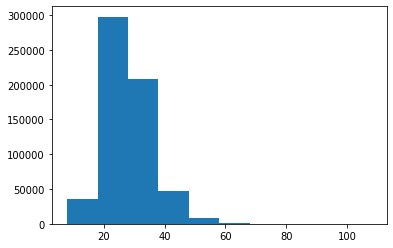

In [16]:
#Посмотрим на полученное распределение длин визуально
import matplotlib.pyplot as plt

plt.hist(len_list)

Как видим, праздник заканчивается в районе 50 :)

In [17]:
MAXLEN = 48

## Часть 2. Задание пайплайна обучения (2 балла)

**Внимание**. За эту часть можно получить ненулевой балл, только при демонстрации того, что ваша модель хоть как-то обучается и  работает.

### Датасет и загрузчик

Создайте датасет, из которого **DataLoader** будет брать объекты для формирования батчей.

In [18]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    
    def __init__(self, corpus, targets):
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        #pass
        self.input_ids_list = []
        self.token_type_ids_list = []
        self.targets = targets

        for item in corpus:
          #чтобы далее в паддингах использовать .size()
          input_item_array = np.array(item['input_ids'])
          token_type_item_array = np.array(item['token_type_ids'])
          #список таких массивов
          self.input_ids_list.append(input_item_array)
          self.token_type_ids_list.append(token_type_item_array)

    def __len__(self):
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        #pass
        return len(self.targets)
    
    def __getitem__(self, idx):
        """
        Returns:
            obj: (input_ids, token_type_ids, target)
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        #pass
        obj = (self.input_ids_list[idx], self.token_type_ids_list[idx], self.targets[idx])
        return obj

In [19]:
ds = MyDataset(train['enc'], train['target'])

test_dataset(ds)

Реализуйте технику динамического паддинга батчей, используя функцию **collate_fn**, которую можно передать как одноименный параметр в класс **DataLoader**.

**hint**: удобно использовать метод **torch.nn.utils.rnn**. Обратите особое внимание на параметр *batch_first*

In [20]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, pad_idx=0):
    """
        Args:
            batch: list of objects
            pad_idx: padding idx
        Returns:
            padded ids, token_type_ids, labels
    """
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    #pass
    padded_ids = pad_sequence([torch.tensor(i[0]) for i in batch], batch_first = True, padding_value = pad_idx) #input
    token_type_ids = pad_sequence([torch.tensor(j[1]) for j in batch], batch_first = True, padding_value = pad_idx) #token_type
    labels = torch.tensor([k[2] for k in batch]) #target

    return padded_ids, token_type_ids, labels

test_collator(ds, collate_fn)

In [21]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)

### Модель


В библиотеке **transformers** есть классы для модели BERT, уже настроенные под решение конкретных задач, с соответствующими головами классификации. Но гораздо более гибкий подход --- использовать энкодер BERT и, по необходимости, входной слой BERT.

Существует два способа задания модели:
* с помощью конфига **transformers.BertConfig**, в котором указываются все гиперпараметры модели
* с помощью подгрузки предобученной модели. Можно загружать как свои предобученные модели, указав путь, так и готовые предобученные модели, указав название конфигурации. В данном задании мы уже выбрали как модель базовую конфигурацию *BERT base*:

In [22]:
from transformers import BertModel

bert = BertModel.from_pretrained(BERT_MODEL)

Напишите модель-обертку, которая:
* принимает на вход название конфигурации (или путь к предобученной модели) и загружает как свой внутренний слой, обычно называемый *backbone* слоем
* создает голову для классификации
* при вызове метода **forward** использует векторное представление токена [CLS] с последнего слоя для классификации

На вход BERT принимает:
* input_ids --- непосредственно индексы ваших токенов в словаре
* attention_mask --- булеву маску со значениями FALSE для всех PAD_IDX токенов
* token_type_ids --- индексы принадлежности токена к 1 или 2 вопросу

**hint:** в статье про BERT авторы опустили следующий архитектурный момент - представление CLS токена используется для NSP задачи, но перед классификацией оно проходит через так называемый **pooler** слой - линейный слой с *tanh* в качестве функции активации, который сохраняет размерность (т.е. на выходе оставляет hidden size значений). Если вы хотите использовать выход именно *pooler* слоя, нужно использовать вектор, получаемый из энкодера как второй элемент кортежа.

In [23]:
from torch import nn
import torch

class BERTClassifier(nn.Module):

    def __init__(self, bert, n_classes=1):
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        #pass
        super().__init__()
        self.bert = bert
        self.hidden_size = 768
        self.n_classes = n_classes
        self.linear = nn.Linear(self.hidden_size, self.n_classes)
        
    @classmethod
    def from_pretrained(cls, path, n_classes=1):
        bert = BertModel.from_pretrained(path)
        return cls(bert, n_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        """
            Args:
                input_ids: token ids, shape = [batch_size, sequence_length]
                attention_mask: masks out padding tokens, shape = [batch_size, sequence_length]
                token_type_ids: segmend ids, shape = [batch_size, sequence_length]
            Returns:
                predictions, shape [batch_size]
        """
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        #pass
        full_output = self.bert(input_ids = input_ids, token_type_ids = token_type_ids, attention_mask = attention_mask)
        #второй элемент
        output = self.linear(full_output[1])
        #shape = ([32, 1])
        return torch.sigmoid(output[:, 0])

In [34]:
device = torch.device('cuda')

model = BERTClassifier.from_pretrained(BERT_MODEL, n_classes=1).to(device)

test_model(dataloader, model, device)

### Оптимизатор

Для оптимизации **BERT** будем использовать **AdamW** c увеличенным learning rate'ом для параметров головы-классификатора. 

Отличие **AdamW** от **Adam** заключается в более корректной реализации $l_2$ регуляризации, которая задается параметром **weight_decay** при инициализации.

Параметры необходимо объединить на три группы:

* параметры, которым нужен weight decay --- все параметры из backbone, кроме сдвигов (bias) и LayerNorm слоев.
* остальные парамеры из backbone
* параметры головы классификации, для которых мы будем задавать гораздо больший learning rate

Будем использовать **model.named_parameters()**, чтобы разделить параметры на три группы, исходя из названий слоев.

In [25]:
NO_DECAY = ['bias', 'LayerNorm.weight']

def is_backbone(name):
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    #pass
    #bert или linear
    if 'bert' in name:
      return 'True'
    else:
      return 'False'

def needs_decay(name):
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    #pass
    if any(nd in name for nd in NO_DECAY):
      return 'False'
    else:
      return 'True'

def get_optimizer(model, lr, weight_decay, head_lr):
    grouped_parameters = [
        {
            'params': [param for name, param in model.named_parameters() if is_backbone(name) and needs_decay(name)],
            'lr': lr,
            'weight_decay': weight_decay,
        },
        {
            'params': [param for name, param in model.named_parameters() if is_backbone(name) and not needs_decay(name)],
            'lr': lr,
            'weight_decay': 0.,
        },
        {
            'params': [param for name, param in model.named_parameters() if not is_backbone(name)],
            'lr': head_lr,
            'weight_decay': weight_decay,
        }
    ]

    optimizer = torch.optim.AdamW(grouped_parameters, lr, weight_decay=weight_decay)

    return optimizer

LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001
HEAD_LEARNING_RATE = 0.0001

optimizer = get_optimizer(model, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, head_lr=HEAD_LEARNING_RATE)

### Scheduler


Также необходимо задать расписание для learning rate. Для **BERT** используется **linear warmup**. 

В **transformers** есть реализация **linear warmup** с помощью метода **transformers.get_linear_schedule_with_warmup**, в которой learning rate стартует с 0, и в течение **num_warmup_steps** линейно возрастает до значения, указанного в качестве стартового в оптимизаторе. Затем в течение **num_training_steps - num_warmup_steps** learning rate линейно падает до 0.

Используйте *dataloader.dataset* и *dataloader.batch_size*, чтобы рассчитать *num_training_steps* исходя из количества эпох. В случае нашей задачи одной эпохи должно быть достаточно для обучения модели.

В случае ограниченного количества видеопамяти может возникнуть ситуация, при которой батч нужного размера не влезает в видеокарту. Для таких ситуаций предлагается использовать аккумуляцию градиента - накапливание градиента в течение *accumulation_steps* с последующим шагом спуска. Т.е. делать *(loss / accumulation_steps).backward()* для каждого батча, и при этом каждые *accumulation_steps* шагов делать *optimizer.step()*.

При обучении количество шагов warmup выбирают либо как 10000 шагов, либо как 0.01% или 0.06% от всех шагов.

In [26]:
import transformers
from transformers import get_linear_schedule_with_warmup

def get_scheduler(optimizer, dataloader, n_epochs, accumulation_steps, warmup_percentage):
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    #pass
    steps_per_epoch = len(dataloader)
    steps = n_epochs * steps_per_epoch
    warmup_steps = steps * warmup_percentage
    sheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, steps)
    return sheduler

N_EPOCHS = 1
ACCUMULATION_STEPS = 1
WARMUP_PERCENTAGE = 0.01

scheduler = get_scheduler(
    optimizer, dataloader, n_epochs=N_EPOCHS, accumulation_steps=ACCUMULATION_STEPS, warmup_percentage=WARMUP_PERCENTAGE
)

Для проверки качества модели необходимо использовать подготовленный для задания **Evaluator**. Важный момент: при использовании, evaluator переводит модель в режим валидации: model.eval(). Во время обучения необходимо самостоятельно переключать ее на model.train() после каждого использования.

На вход evaluator принимает вашу модель и device (CUDA или CPU), на котором необходимо считать результаты моделирования. 

При использовании evaluator можно использовать BATCH_SIZE значительно большего размера, потому что отпадает необходимость считать градиенты для параметров.

In [27]:
from utils import Evaluator

ModuleNotFoundError: ignored

Опять продблирую utils

In [52]:
import numpy as np
import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class InferenceDataset(Dataset):
    
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ids = torch.tensor(self.data[idx]['input_ids'], dtype=torch.long)
        type_ids = torch.tensor(self.data[idx]['token_type_ids'], dtype=torch.long)
        return ids, type_ids

    
def collate_fn(batch, pad_idx=0):
    ids, type_ids = map(lambda x: pad_sequence(x, batch_first=True, padding_value=pad_idx), zip(*batch))
    return ids, type_ids


def hits_count(dup_ranks, k):
    ranks = [rank <= k for rank in dup_ranks]
    return 0. if not ranks else np.mean(ranks)


def dcg_score(dup_ranks, k):
    vals = [1. / np.log2(1. + rank) for rank in dup_ranks if rank <= k]
    return 0. if not vals else np.sum(vals) / len(dup_ranks)


class Evaluator:

    def __init__(self, path, tokenizer, maxlen, batch_size, pad_idx=0, verbose=False):
        self.tokenizer = tokenizer
        self.maxlen = maxlen
        self.pad_idx = pad_idx
        
        data = []
        for line in open(path, encoding='utf-8'):
            data.append(line.strip().split('\t'))

        lengths = []
        prep_data = []
        for query, *docs in tqdm.tqdm(data, disable=not verbose, desc='Encoding text...'):
            for doc in docs:
                prep_data.append(self.encode(query, doc))
            lengths.append(len(docs))
        self.bounds = np.cumsum([0] + lengths)
        self.ids, prep_data = zip(*sorted(enumerate(prep_data), key=lambda x: len(x[1]['input_ids'])))

        ds = InferenceDataset(prep_data)
        self.dataloader = DataLoader(ds, batch_size, collate_fn=collate_fn)
        
    def __call__(self, model, device, verbose=False):
        model.to(device)
        model.eval()
        
        preds = []
        for batch in tqdm.tqdm(self.dataloader, disable=not verbose, desc='Computing predictions...'):
            input_ids, token_type_ids = map(lambda x: x.to(device), batch)
            attention_mask = input_ids != self.pad_idx
            with torch.no_grad():
                pred = model(input_ids, attention_mask, token_type_ids).cpu()
            preds.append(pred)
        preds = torch.cat(preds).numpy()
        
        _, preds = zip(*sorted(zip(self.ids, preds), key=lambda x: x[0]))
        
        rankings = []
        for i in range(len(self.bounds) - 1):
            rankings.append(
                list(np.argsort(-np.array(preds[self.bounds[i]:self.bounds[i + 1]]))).index(0) + 1
            )
            
        metrics = {
            'DCG': {f'DCG@{k}': dcg_score(rankings, k) for k in [1, 5, 10, 100, 500, 1000]},
            'Hits': {f'Hits@{k}': hits_count(rankings, k) for k in [1, 5, 10, 100, 500, 1000]}
        }
        
        return metrics
            
    def encode(self, query, doc):
        enc = self.tokenizer.encode_plus(query, doc, add_special_tokens=True)
        return {'input_ids': enc.input_ids[:self.maxlen], 'token_type_ids': enc.token_type_ids[:self.maxlen]}

In [29]:
evaluator = Evaluator(os.path.join(DATA_PATH, 'validation.tsv'), tokenizer, maxlen=MAXLEN, batch_size=1024)
metrics = evaluator(model, device, verbose=True)
metrics

Computing predictions...: 100%|██████████| 98/98 [03:01<00:00,  1.85s/it]


{'DCG': {'DCG@1': 0.52,
  'DCG@10': 0.6044309951592103,
  'DCG@100': 0.6310030269090201,
  'DCG@1000': 0.6540623227798987,
  'DCG@5': 0.594703974563633,
  'DCG@500': 0.6499113729145151},
 'Hits': {'Hits@1': 0.52,
  'Hits@10': 0.68,
  'Hits@100': 0.81,
  'Hits@1000': 1.0,
  'Hits@5': 0.65,
  'Hits@500': 0.96}}

Данный **evaluator** предлагается использовать не только для оценки итогового качества, но также для вывода промежуточных результатов на dev сете в логи с помощью **torch.utils.tensorboard.SummaryWriter**.

Перед обучением необходимо создать объект данного класса, указав папку для записи логов.

Во время обучения через каждые $10000$ объектов необходимо записывать значения метрик в логи с помощью методов **writer.add_scalars**. Кроме того, необходимо записывать значение функционала ошибки на каждом батче во время обучения с помощью метода **writer.add_scalar**.

## Часть 3. Обучение модели (7 баллов)

Ниже предлагаются примерные значения гиперпараметров, приводящие к необходимым метрикам качества. Для подбора точных значений гиперпараметров предлагается использовать *dev set*.

**Гиперпараметры для обучения:**

* размер батча в $\{32, 64\}$
* клиппинг нормы градиента (используйте **torch.nn.utils.clip_grad_norm_**)
* шаг обучения в $\{$1e-5, 2e-5, 3e-5, 4e-5$\}$
* weight decay в $\{$1e-2, 1e-3, 1e-4$\}$
* warmup percentage в $\{0.01, 0.06\}$
* шаг обучения для головы-классификатора в $\{10, 50, 100\}$ раз больше, чем для остальных параметров

In [30]:
from torch.utils.tensorboard import SummaryWriter

###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
logs = SummaryWriter('logs/')
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.01
WARMUP_PERCENTAGE = 0.01
HEAD_LEARNING_RATE = 0.001
N_EPOCHS = 3

In [41]:
from torch.nn import BCELoss
evaluator = Evaluator(os.path.join(DATA_PATH, 'validation.tsv'), tokenizer, maxlen=MAXLEN, batch_size=1024)

In [54]:
from tqdm.notebook import tqdm as tqdm_n
model.to(device)
model.train()
loss_func = BCELoss()
train_loss = []

for epoch in range(N_EPOCHS):
  for step, batch in enumerate(tqdm_n(dataloader)):
    padded_ids, token_type_ids, labels = batch
    output = model(input_ids = padded_ids.to(device), token_type_ids = token_type_ids.to(device), attention_mask = None)
    loss = loss_func(output.float().to(device), labels.float().to(device))
    loss = loss / ACCUMULATION_STEPS
    train_loss.append(loss)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    logs.add_scalar('Loss/train', loss.float(), step)

    if (step + 1) % ACCUMULATION_STEPS == 0:
      optimizer.step() 
      scheduler.step()
      optimizer.zero_grad()

    if step % (10 * ACCUMULATION_STEPS) == 0:
      metrics = evaluator(model, device, verbose=False)
      logs.add_scalars('Eval/Hits', metrics["Hits"], step)
      logs.add_scalars('Eval/DCG', metrics["DCG"], step)

      model.train()
logs.close()

KeyboardInterrupt: ignored

In [ ]:
dev_metrics = evaluator(model, device)
dev_metrics

In [ ]:
test_evaluator = Evaluator(os.path.join(DATA_PATH, 'test.tsv'), tokenizer, maxlen=MAXLEN, batch_size=1024)
test_metrics = test_evaluator(model, device, verbose=True)
test_metrics

Задание будет засчитано на полный балл при *Hits@1* на *test set* больше $0.6$. Необходимо приложить логи из тензорборда, а также скриншот этих самых логов.

## Бонусная часть (до 6 баллов)

### ELMO-подобная архитектура для головы-классификатора (до 2 баллов)

Реализуйте и обучите ELMO-подобную архитектуру для головы-классификатора: берутся все 13 векторных представлений CLS токена, и затем с обучаемыми софтмакс-нормализуемыми весами складываются перед линейным классификатором. Дообучаются ВСЕ веса, включая сам берт. Можно попробовать зафризить исходный берт, но с большой вероятностью наибольшее качество достигается при дообучении всего.

Рекомендуется инициализировать обучаемые веса равными значениями, а также наряду с головой-классификатором присвоить им learning rate, значительно больший по значению, чем у энкодера.

Требуется получить качество хотя бы примерно такое же (а желательно и выше), чем при основной архитектуре. Может понадобиться больше эпох для обучения!


In [ ]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

### Улучшение качества на том же наборе данных (до 2 баллов)

Можно использовать любые способа для улучшения качества, КРОМЕ изменения датасетов. Например:

* Multi-sample Dropout --- при обучении, перед головой классификации итоговый вектор прогоняется через Dropout *n*-ное количество раз, каждый из полученных векторов проводится через голову классификации, и результаты усредняются.
* Изменения в архитектуре энкодера --- попробовать large конфигурацию, поменять функцию активации и прочие гиперпараметры, взять предобученный альберт из huggingface c пошаренными весами в энкодере
* попробовать дотюнить bert на MLM задачу (как в ULMFiT) перед дообучением на задачу классификации
* попробовать другие головы классификации - elmo-like голову, макс/авг пулинг по всем токенам или по всем векторам CLS токена, конкатенацию векторов CLS токена; сверточную сеть для классификации

Требуется получить Hits@1 $ \geqslant 0.65$

In [ ]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

### Улучшение качества с генерацией нового тренировочного набора (до 2 баллов)

Для формирования тренировочной выборки в данном задании использовался *train_data* из первой домашней работы. Были взяты $100000$ пар дубликатов, и для первого дубликата из каждой пары также было сгенерировано 5 отрицательных примеров с помощью негативного сэмплирования. Предлагается самостоятельно сгенерировать тренировочную выборку, подобрать наилучший размер, а также количество негативных сэмплов.

Валидироваться надо на тех же самых датасетах.

Требуется получить Hits@1 $\geqslant0.7$

In [ ]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

P.S.: возможна корректировка дополнительных баллов по результатам выполнения бонусов. Рекомендуется в любом случае попробовать их сделать, даже если не получится получить нужное значение метрики :)